# A simple example of training and make prediction with TimesNet model.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import DistributionLoss
from neuralforecast.utils import AirPassengersPanel, augment_calendar_df
from neuralforecast.models import TimesNet


## Load dataset

In [2]:
AirPassengersPanel, calendar_cols = augment_calendar_df(df=AirPassengersPanel, freq='M')

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test


## Build model

In [3]:
model = TimesNet(h=12,
                input_size=24,
                hidden_size = 16,
                conv_hidden_size = 32,
                loss=DistributionLoss(distribution='Normal', level=[80, 90, 95, 99]),
                futr_exog_list=calendar_cols,
                scaler_type='standard',
                learning_rate=1e-3,
                max_steps=5,
                val_check_steps=50,
                early_stop_patience_steps=2)

nf = NeuralForecast(
    models=[model],
    freq='M'
)

Seed set to 1


## Number model parameters

In [4]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Model has {params} parameters')

Model has 587334 parameters


## Fit model and make predict

In [5]:
# nf.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
# forecasts = nf.predict(futr_df=Y_test_df)

Due to the fact that the model takes a very long time to be trained, let's load the forecast results.

In [6]:
forecast = pd.read_csv('model/forecast.csv')

## Plot results

In [7]:
Y_train_plot = Y_train_df.loc[Y_train_df['unique_id'] == 'Airline1', ['ds', 'y']]
Y_test_plot = Y_test_df.loc[Y_test_df['unique_id'] == 'Airline1', ['ds', 'y']]
Y_forecast_plot = forecast.loc[forecast['unique_id'] == 'Airline1'].drop(columns=['unique_id'])
Y_forecast_plot['ds']= pd.to_datetime(Y_forecast_plot['ds'])

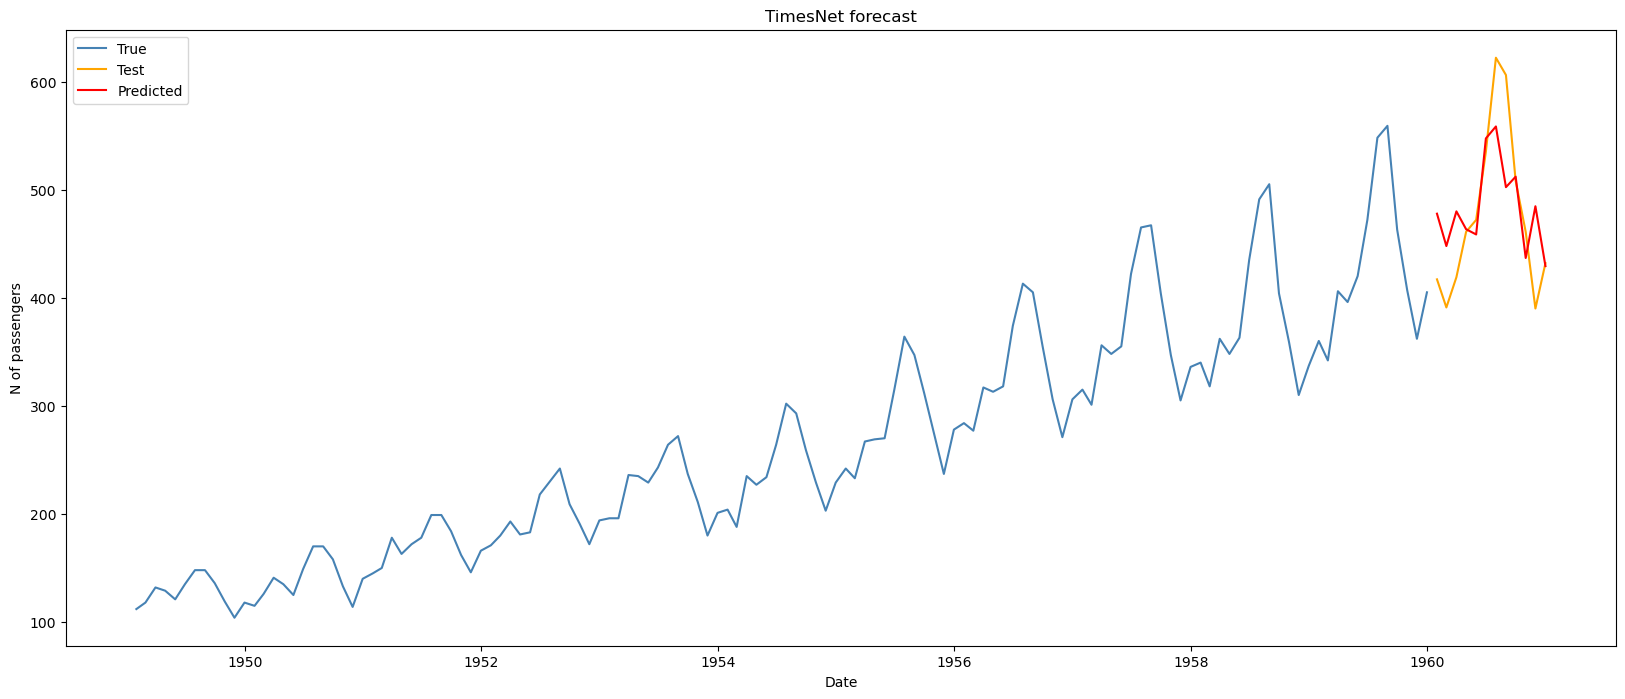

In [8]:
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(Y_train_plot['ds'], Y_train_plot['y'], c='steelblue', label='True')
plt.plot(Y_test_plot['ds'], Y_test_plot['y'], c='orange', label='Test')
plt.plot(Y_forecast_plot['ds'], Y_forecast_plot['TimesNet'], c='red', label='Predicted')
plt.legend()
plt.title('TimesNet forecast')
plt.xlabel('Date')
plt.ylabel('N of passengers')
plt.show()

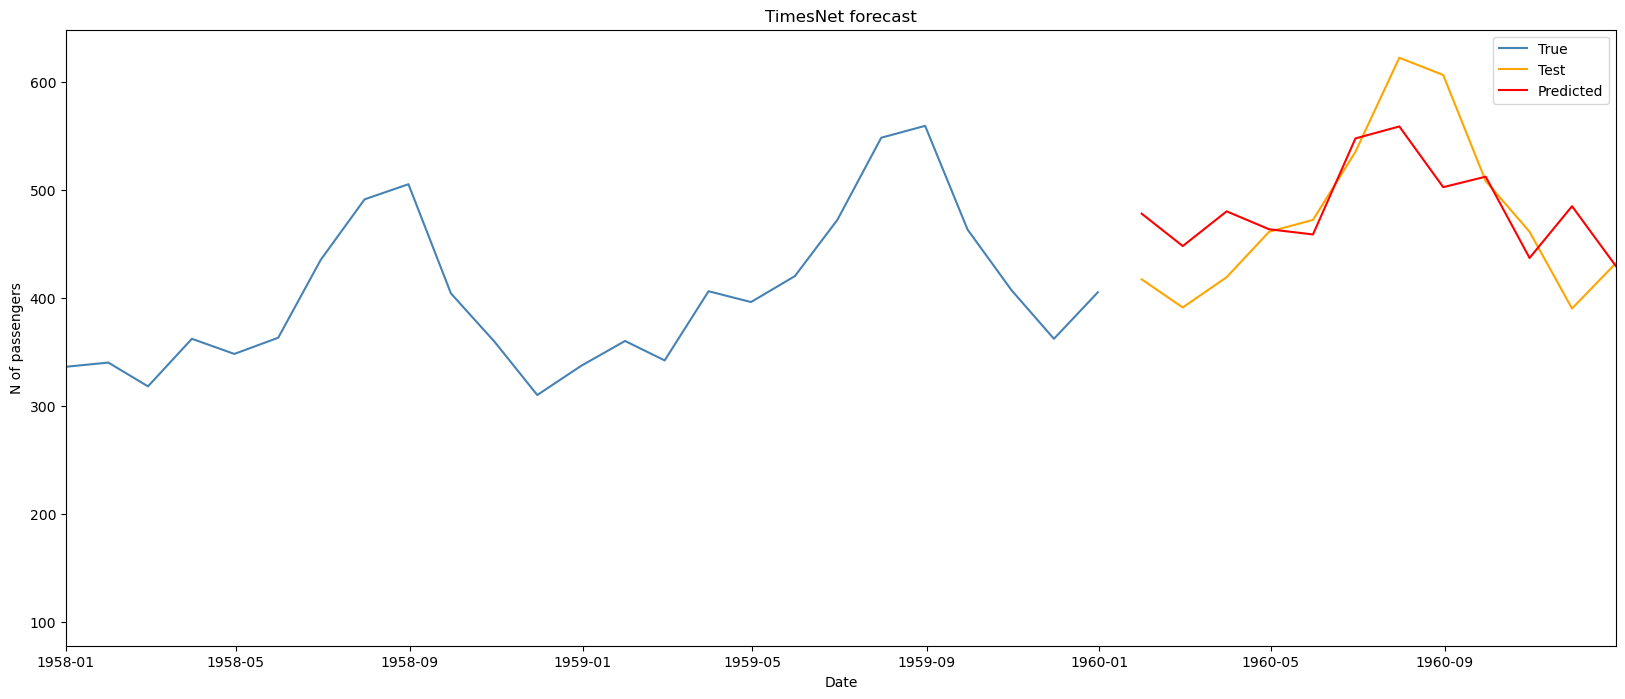

In [9]:
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(Y_train_plot['ds'], Y_train_plot['y'], c='steelblue', label='True')
plt.plot(Y_test_plot['ds'], Y_test_plot['y'], c='orange', label='Test')
plt.plot(Y_forecast_plot['ds'], Y_forecast_plot['TimesNet'], c='red', label='Predicted')
plt.xlim(pd.Timestamp('1958-01-01'), Y_forecast_plot['ds'].max())
plt.legend()
plt.title('TimesNet forecast')
plt.xlabel('Date')
plt.ylabel('N of passengers')
plt.show()

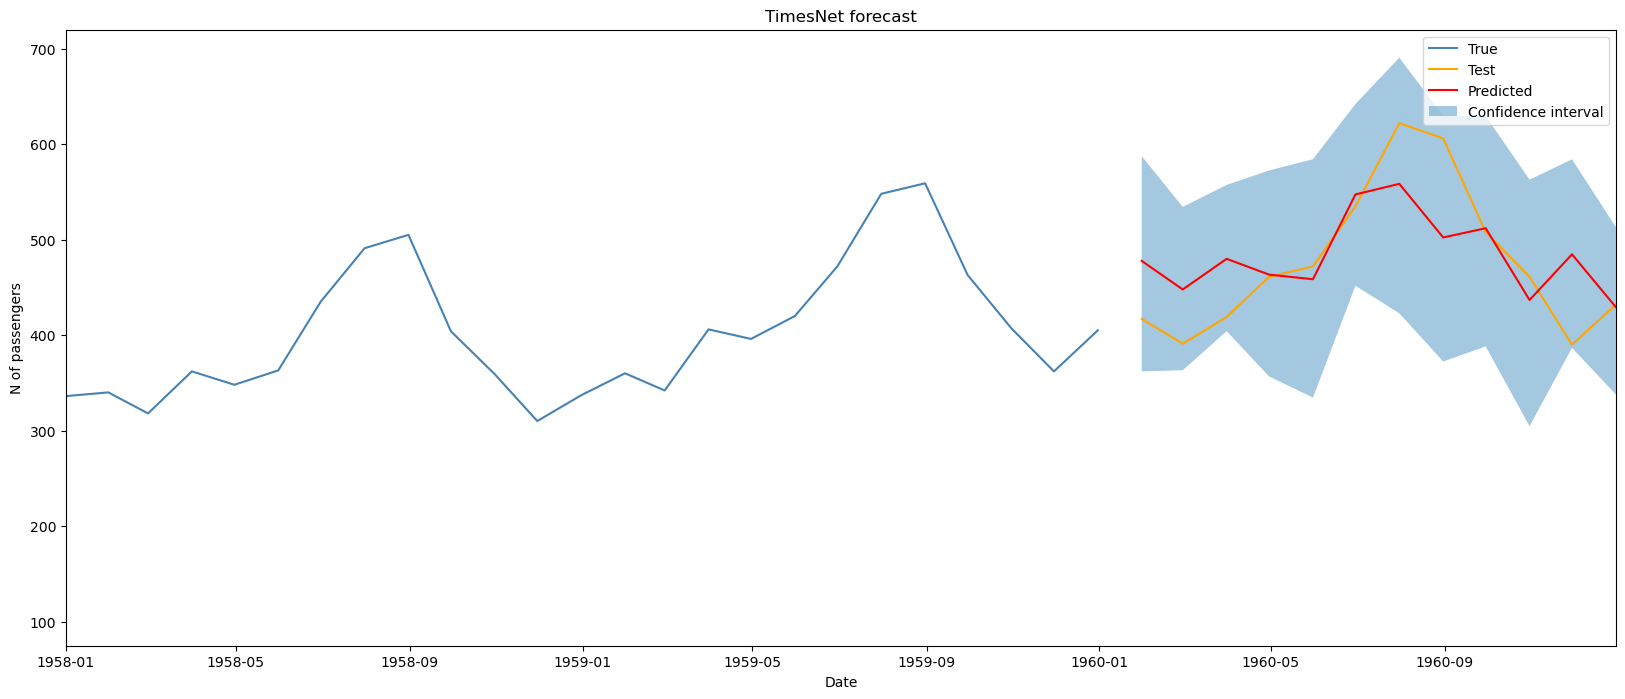

In [10]:
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(Y_train_plot['ds'], Y_train_plot['y'], c='steelblue', label='True')
plt.plot(Y_test_plot['ds'], Y_test_plot['y'], c='orange', label='Test')
plt.plot(Y_forecast_plot['ds'], Y_forecast_plot['TimesNet'], c='red', label='Predicted')
plt.xlim(pd.Timestamp('1958-01-01'), Y_forecast_plot['ds'].max())
plt.fill_between(x=Y_forecast_plot['ds'], 
                    y1=Y_forecast_plot['TimesNet-lo-80'][-12:].values, 
                    y2=Y_forecast_plot['TimesNet-hi-80'][-12:].values,
                    alpha=0.4, label='Сonfidence interval')
plt.legend()
plt.title('TimesNet forecast')
plt.xlabel('Date')
plt.ylabel('N of passengers')
plt.legend()
plt.show()
